In [91]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import scipy
from scipy import signal, stats
from scipy.stats import pointbiserialr
import math
from math import sqrt

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, permutation_test_score, cross_validate
from sklearn.base import clone

sns.set_theme(style="whitegrid")

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

import mrmr

### K-Nearest Neighbors

In [110]:
response = pd.read_csv('response.csv', sep=';') # Read the response data
features = pd.read_csv('surrogate_18042022.csv', index_col=0) # Read the features dataframe

selected_features = ['PDC_beta_SLEEP_GE', 'wPLI_broadband_SLEEP_MEAN_SYNCH', 'PDC_delta_SLEEP_AVGCC',
                     'wPLI_alpha_SLEEP_MEAN_SYNCH', 'PDC_broadband_SLEEP_GE', 'wPLI_beta_SLEEP_MEAN_SYNCH']

full_df = pd.merge(features, response, on='patient', how='outer') # Join the two dataframes
full_df = full_df.dropna() # Drop the NaN values
full_df.loc[full_df["response"] == "RP", "response"] = 1
full_df.loc[full_df["response"] == "PR", "response"] = 1
full_df.loc[full_df["response"] == "R", "response"]  = 1
full_df.loc[full_df["response"] == "NR", "response"] = 0

full_df.drop(columns=['patient'], inplace=True)
full_df = full_df[selected_features + ['response']]

#train=full_df.copy()#.sample(n=30, random_state=42)
train=full_df.sample(n=30, random_state=42)
test=full_df.drop(train.index)
full_df = train.sort_index().copy()
test_df = test.copy()

In [111]:
X = full_df.drop(columns=['response'], inplace=False)
Y = full_df['response']

X_test = test_df.drop(columns=['response'], inplace=False)
Y_test = test_df['response'].to_numpy(dtype='int')

X_train = X.to_numpy()
Y_train = Y.to_numpy(dtype='int')

model = Pipeline(steps=[('scaler', MinMaxScaler()), ('ml_model', KNeighborsClassifier(leaf_size=1, n_neighbors=13))])
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test.to_numpy())

test_acc = accuracy_score(Y_test, Y_pred)

print(f'The test accuracy obtained for the model is: {test_acc}')

The test accuracy obtained for the model is: 0.8571428571428571


In [112]:
Y_pred

array([1, 0, 1, 1, 1, 1, 0])

In [114]:
Y_test

array([0, 0, 1, 1, 1, 1, 0])

In [80]:
n_uncorrelated_features = 6
rng = np.random.RandomState(seed=42)
# Use same number of samples as in iris and 20 features
#X_rand = rng.normal(size=(X.shape[0], n_uncorrelated_features))

cv = KFold(6, shuffle=True, random_state=42)

score_iris, perm_scores_iris, pvalue_iris = permutation_test_score(
    model, X, Y.to_numpy(dtype='int'), scoring="accuracy", cv=cv, n_permutations=1000
)

#score_rand, perm_scores_rand, pvalue_rand = permutation_test_score(
#    model, X_rand, Y.to_numpy(dtype='int'), scoring="accuracy", cv=cv, n_permutations=1000
#)

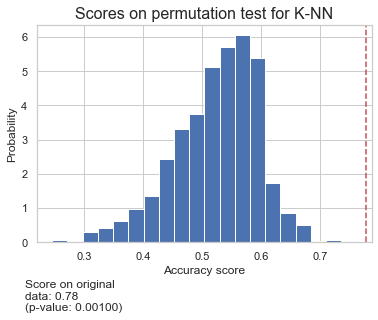

In [82]:
fig, ax = plt.subplots()

ax.hist(perm_scores_iris, bins=20, density=True)
ax.axvline(score_iris, ls="--", color="r")
score_label = f"Score on original\ndata: {score_iris:.2f}\n(p-value: {pvalue_iris:.5f})"
ax.text(0.2, -2, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")
ax.set_title('Scores on permutation test for K-NN', fontsize=16)
plt.savefig('permutation_score_knn.pdf', bbox_inches='tight')

### Gaussian process

In [ ]:
response = pd.read_csv('response.csv', sep=';') # Read the response data
features = pd.read_csv('surrogate_18042022.csv', index_col=0) # Read the features dataframe

selected_features = ['PDC_beta_SLEEP_GE', 'wPLI_alpha_SLEEP_MEAN_SYNCH', 'PDC_alpha_AWAKE_MOD',
                     'wPLI_beta_SLEEP_MEAN_SYNCH', 'PDC_delta_SLEEP_AVGCC', 'PDC_broadband_SLEEP_GE',
                     'wPLI_broadband_SLEEP_MEAN_SYNCH']

full_df = pd.merge(features, response, on='patient', how='outer') # Join the two dataframes
full_df = full_df.dropna() # Drop the NaN values
full_df.loc[full_df["response"] == "RP", "response"] = 1
full_df.loc[full_df["response"] == "PR", "response"] = 1
full_df.loc[full_df["response"] == "R", "response"]  = 1
full_df.loc[full_df["response"] == "NR", "response"] = 0

full_df.drop(columns=['patient'], inplace=True)
full_df = full_df[selected_features + ['response']]

train=full_df.copy()#.sample(n=30, random_state=42)
#train = full_df.sample(n=30, random_state=42)
test=full_df.drop(train.index)
full_df = train.sort_index().copy()
test_df = test.copy()

In [ ]:
X = full_df.drop(columns=['response'], inplace=False)
Y = full_df['response']

X_test = test_df.drop(columns=['response'], inplace=False)
Y_test = test_df['response'].to_numpy(dtype='int')

X_train = X.to_numpy()
Y_train = Y.to_numpy(dtype='int')

model = Pipeline(steps=[('scaler', MinMaxScaler()),
                ('ml_model',
                 GaussianProcessClassifier(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1)))])
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test.to_numpy())

test_acc = accuracy_score(Y_test, Y_pred)

print(f'The test accuracy obtained for the model is: {test_acc}')

In [74]:
n_uncorrelated_features = 6
rng = np.random.RandomState(seed=42)
# Use same number of samples as in iris and 20 features
X_rand = rng.normal(size=(X.shape[0], n_uncorrelated_features))

cv = KFold(6, shuffle=True, random_state=42)

score_iris, perm_scores_iris, pvalue_iris = permutation_test_score(
    model, X, Y.to_numpy(dtype='int'), scoring="accuracy", cv=cv, n_permutations=1000
)

#score_rand, perm_scores_rand, pvalue_rand = permutation_test_score(
#    model, X_rand, Y.to_numpy(dtype='int'), scoring="accuracy", cv=cv, n_permutations=1000
#)

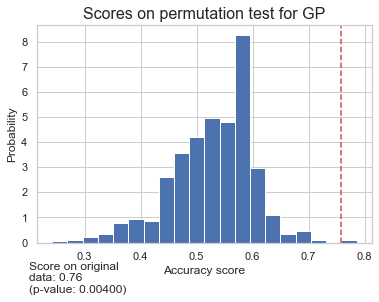

In [77]:
fig, ax = plt.subplots()

ax.hist(perm_scores_iris, bins=20, density=True)
ax.axvline(score_iris, ls="--", color="r")
score_label = f"Score on original\ndata: {score_iris:.2f}\n(p-value: {pvalue_iris:.5f})"
ax.text(0.2, -2, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")
ax.set_title('Scores on permutation test for GP', fontsize=16)
plt.savefig('permutation_score_gp.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()

ax.hist(perm_scores_rand, bins=20, density=True)
ax.set_xlim(0.13)
ax.axvline(score_rand, ls="--", color="r")
score_label = f"Score on original\ndata: {score_rand:.2f}\n(p-value: {pvalue_rand:.3f})"
ax.text(0.14, 7.5, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
ax.set_ylabel("Probability")
plt.show()

### Evaluation using CV

In [86]:
response = pd.read_csv('response.csv', sep=';') # Read the response data
features = pd.read_csv('surrogate_18042022.csv', index_col=0) # Read the features dataframe

selected_features = ['PDC_beta_SLEEP_GE', 'wPLI_alpha_SLEEP_MEAN_SYNCH', 'PDC_alpha_AWAKE_MOD',
                     'wPLI_beta_SLEEP_MEAN_SYNCH', 'PDC_delta_SLEEP_AVGCC', 'PDC_broadband_SLEEP_GE',
                     'wPLI_broadband_SLEEP_MEAN_SYNCH']

full_df = pd.merge(features, response, on='patient', how='outer') # Join the two dataframes
full_df = full_df.dropna() # Drop the NaN values
full_df.loc[full_df["response"] == "RP", "response"] = 1
full_df.loc[full_df["response"] == "PR", "response"] = 1
full_df.loc[full_df["response"] == "R", "response"]  = 1
full_df.loc[full_df["response"] == "NR", "response"] = 0

full_df.drop(columns=['patient'], inplace=True)
full_df = full_df[selected_features + ['response']]

train=full_df.sample(n=30, random_state=42)
test=full_df.drop(train.index)
full_df = train.sort_index().copy()
test_df = test.copy()

In [87]:
X = full_df.drop(columns=['response'], inplace=False)
Y = full_df['response']

X_test = test_df.drop(columns=['response'], inplace=False)
Y_test = test_df['response'].to_numpy(dtype='int')

X_train = X.to_numpy()
Y_train = Y.to_numpy(dtype='int')

model = Pipeline(steps=[('scaler', MinMaxScaler()), ('ml_model', KNeighborsClassifier(leaf_size=1, n_neighbors=13))])
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test.to_numpy())

test_acc = accuracy_score(Y_test, Y_pred)

print(f'The test accuracy obtained for the model is: {test_acc}')

The test accuracy obtained for the model is: 0.8571428571428571


In [109]:
Y_pred

array([1, 0, 1, 1, 1, 1, 0])

In [108]:
Y_test

array([0, 0, 1, 1, 1, 1, 0])

In [104]:
model = Pipeline(steps=[('scaler', MinMaxScaler()), ('ml_model', KNeighborsClassifier(leaf_size=1, n_neighbors=13))])
model.fit(X_train, Y_train)

specificity = make_scorer(recall_score, pos_label=0)
sensitivity = make_scorer(recall_score, pos_label=1)

cv = KFold(n_splits=6, shuffle=True, random_state=42)
cv_perf = cross_validate(model, X=X_train, y=Y_train, scoring={'specificity':specificity, 'sensitivity':sensitivity}, cv=cv)

In [105]:
cv_perf

{'fit_time': array([0.00199366, 0.00099897, 0.0019958 , 0.00199556, 0.00099802,
        0.00199461]),
 'score_time': array([0.00498724, 0.00498676, 0.00199389, 0.00598383, 0.00398874,
        0.00498652]),
 'test_specificity': array([0.33333333, 1.        , 0.66666667, 1.        , 0.33333333,
        0.        ]),
 'test_sensitivity': array([1.        , 0.66666667, 1.        , 0.5       , 1.        ,
        0.6       ])}

In [106]:
cv_perf['test_specificity'].mean()

0.5555555555555556

In [107]:
cv_perf['test_sensitivity'].mean()

0.7944444444444443